In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Utility Functions

In [ ]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Load & Explore Data

In [ ]:
# Load dataset
train_data = pd.read_csv('Training_data.csv')
test_data = pd.read_csv('testing_data.csv')

In [ ]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 1000
Number of samples in test data: 595


In [ ]:
# Explore the dataset
train_data.head()

,1.00E+00,6.59E-01,1.86E-01,7.03E-02,7.03E-02.1,5.95E-02,5.68E-02,4.32E-02,5.41E-02,4.59E-02,...,0.00E+00.84,0.00E+00.85,0.00E+00.86,0.00E+00.87,0.00E+00.88,0.00E+00.89,0.00E+00.90,0.00E+00.91,0.00E+00.92,0.00E+00.93
0,0.925,0.666,0.541,0.276,0.1960,0.0773,0.0718,0.0608,0.06630,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.967,1.000,0.831,0.587,0.3570,0.2490,0.1460,0.0892,0.11700,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.927,1.000,0.627,0.193,0.0950,0.0725,0.0432,0.0535,0.09330,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.424,0.792,1.000,0.257,0.0000,0.2780,0.4650,0.5210,0.47200,0.5560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.717,0.540,0.283,0.130,0.0649,0.0767,0.0265,0.0324,0.00885,0.0442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [ ]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 6


In [ ]:
print(train_data.iloc[:, -1].value_counts())  # Check class distribution in train data

0.00E+00.93
3.0    208
2.0    202
1.0    200
0.0    199
4.0    191
Name: count, dtype: int64


In [ ]:
print(test_data.iloc[:, -1].value_counts())  # Check class distribution in test data

0.00E+00.88
4.0    196
0.0    100
2.0    100
3.0    100
1.0     99
Name: count, dtype: int64


In [ ]:
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [ ]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

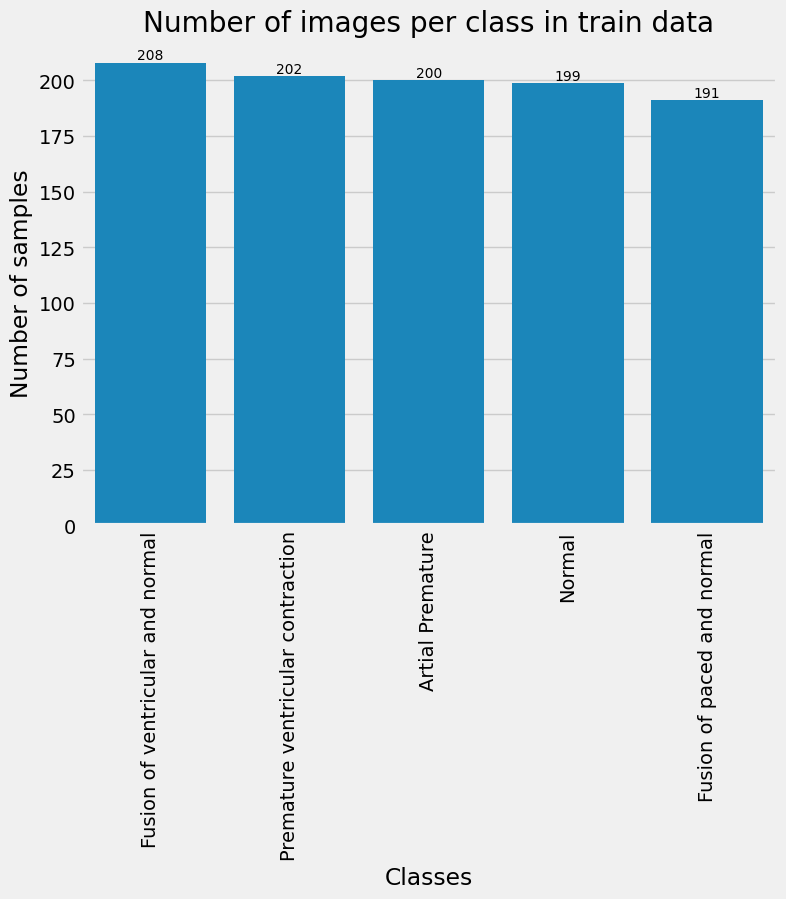

In [ ]:
train_counts = train_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

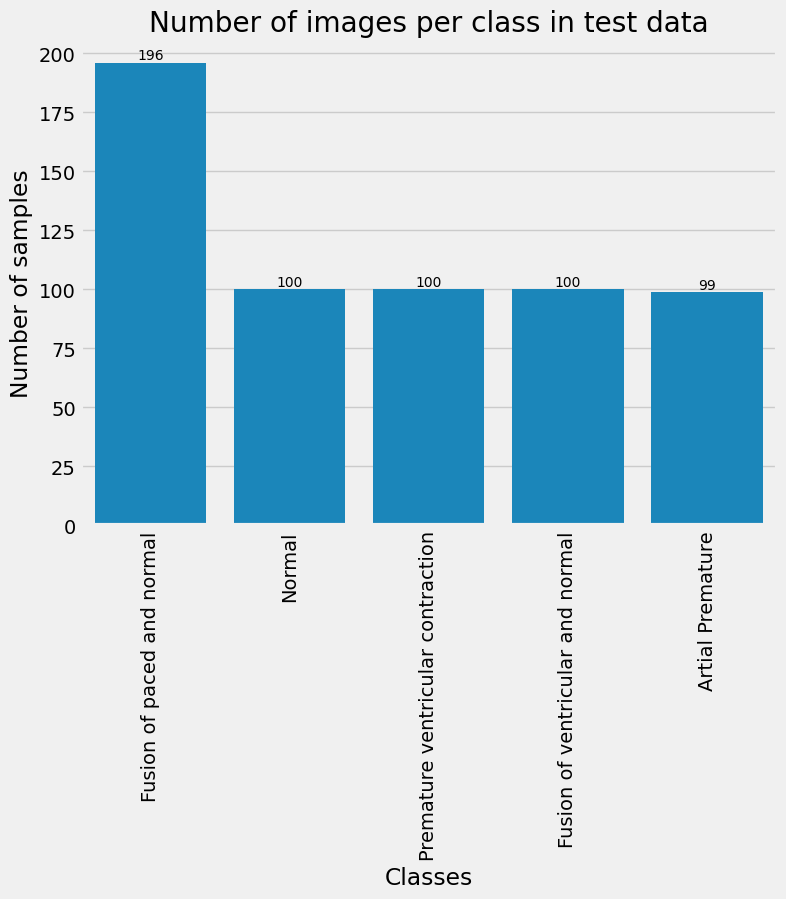

In [ ]:
test_counts = test_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

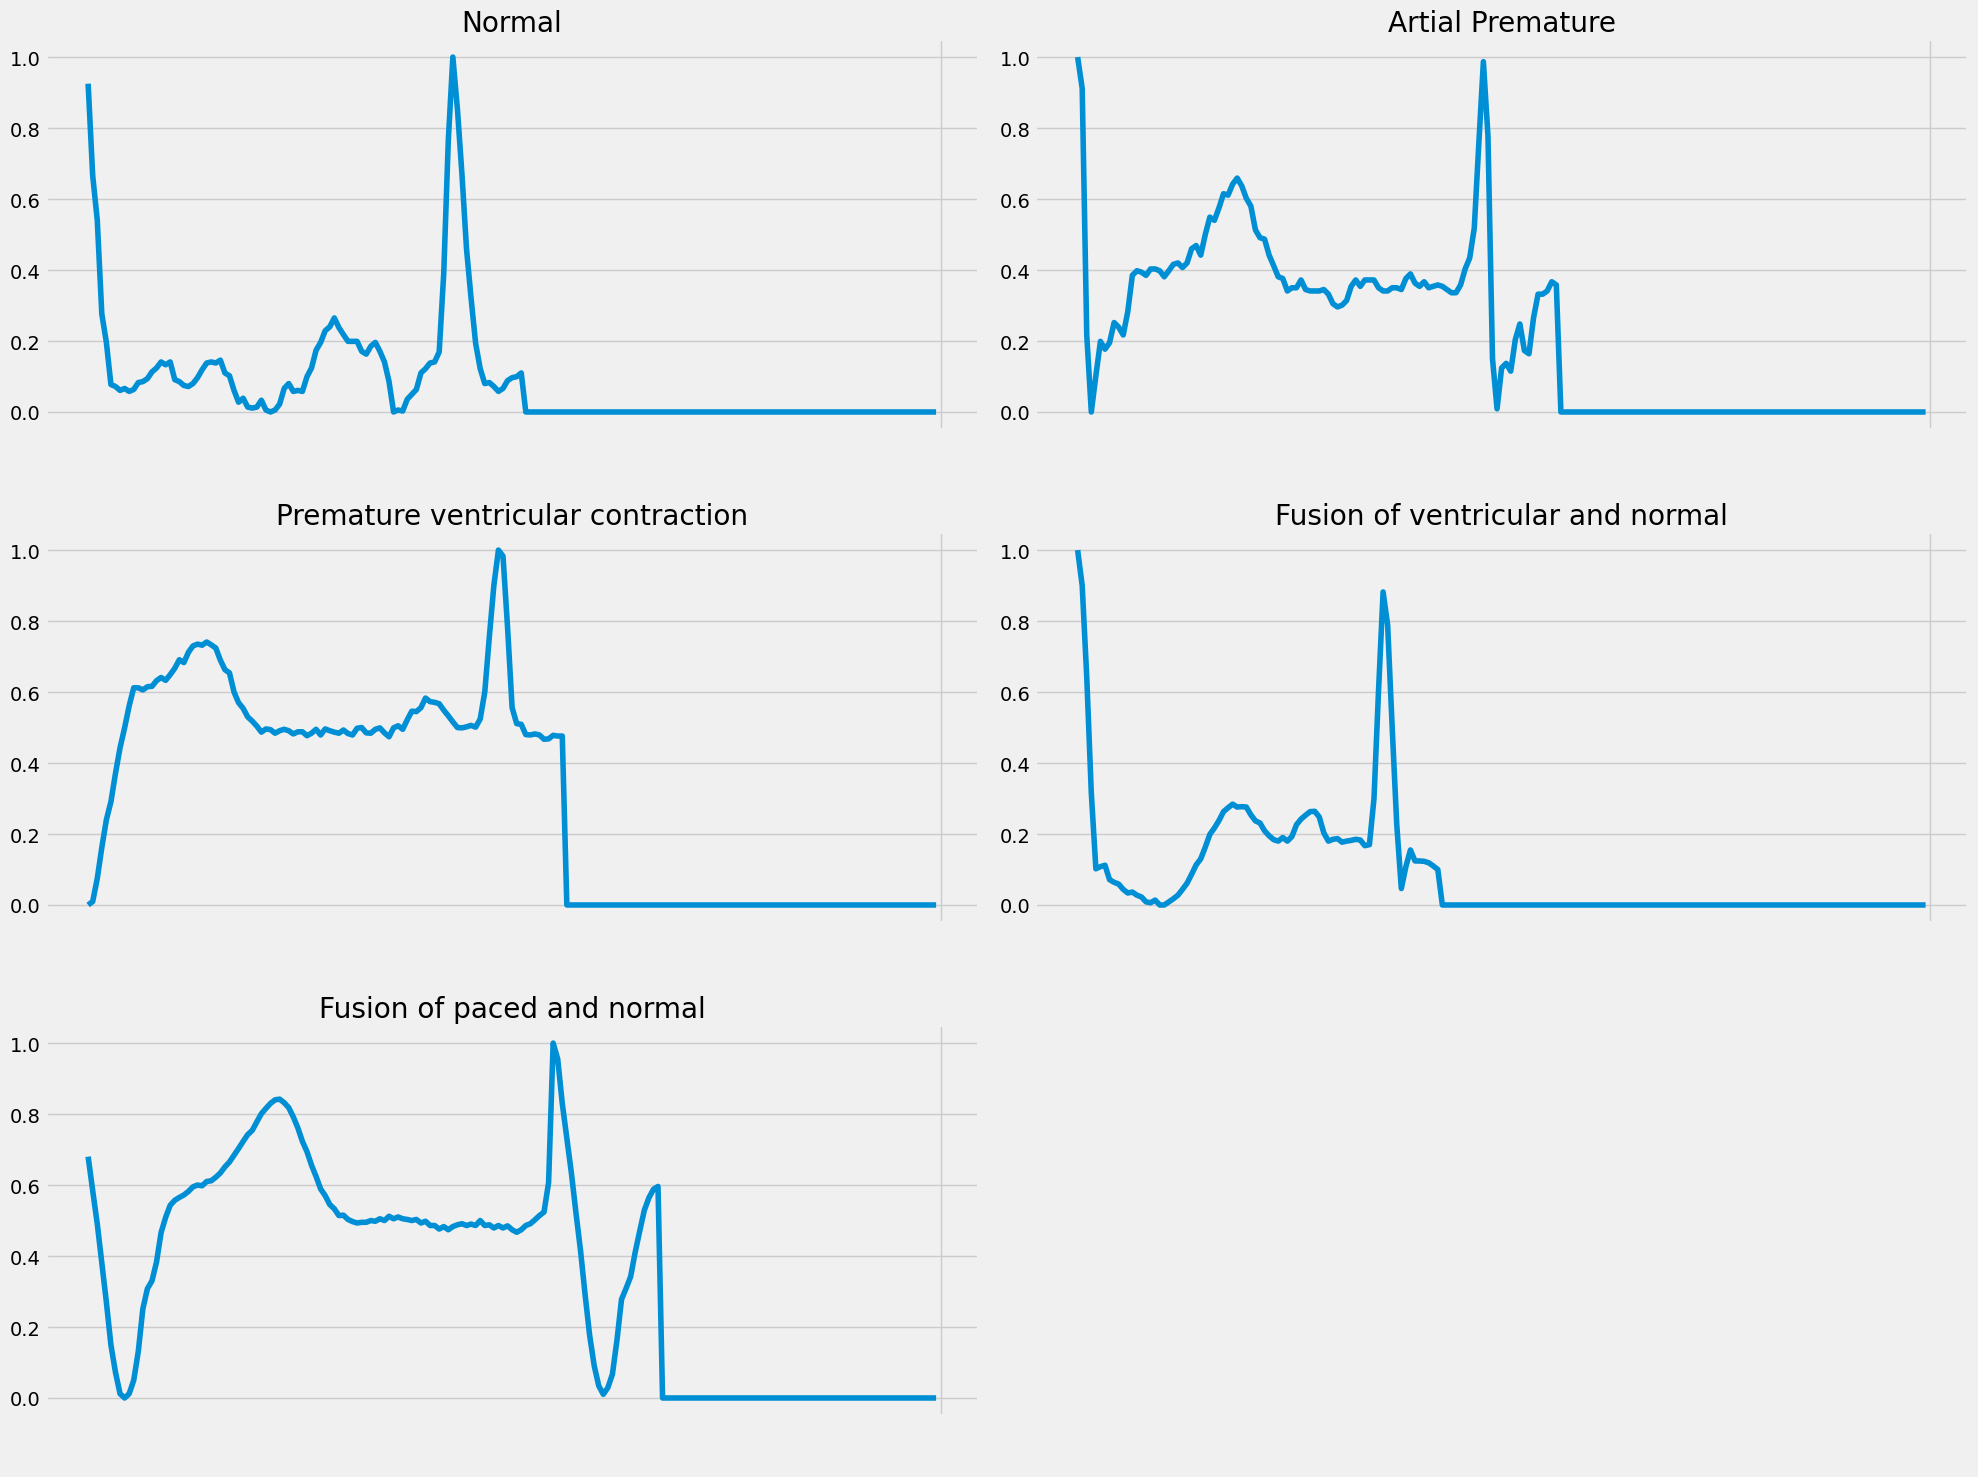

In [ ]:
# Plot each class
train_classes = train_data.iloc[:, -1].unique()

plt.figure(figsize=(20, 15))

# Filter out nan values from train_classes
valid_train_classes = [cls for cls in train_classes if not pd.isnull(cls)]

for i, cls in enumerate(valid_train_classes):
    plt.subplot(3, 2, i + 1)

    # Get the subset of data for the current class
    subset = train_data[train_data.iloc[:, -1] == cls]

    # Check if the subset is empty before accessing data
    if not subset.empty:
        plt.plot(subset.iloc[0, :-1])  # Exclude the label column
        plt.title(f'{list(labels.values())[i]}') # This line might also need adjustment
        plt.xlabel(" ")
        plt.xticks(ticks=" ",labels =" ",rotation=45)
    else:
        print(f"No data found for class: {cls}")

plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Impute or remove NaN values in y_test if any exist
# Check if there are any NaN values in y_test
if np.isnan(y_test).any():
    # Option 1: Remove rows with NaN values
    # rows_with_nan = np.isnan(y_test)
    # X_test = X_test[~rows_with_nan]
    # y_test = y_test[~rows_with_nan]

    # Option 2: Impute NaN values with the most frequent value
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    y_test = imputer.fit_transform(y_test.reshape(-1, 1)).ravel()

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Impute or remove NaN values in y_test if any exist
# Check if there are any NaN values in y_test
if np.isnan(y_test).any():
    # Option 1: Remove rows with NaN values
    # rows_with_nan = np.isnan(y_test)
    # X_test = X_test[~rows_with_nan]
    # y_test = y_test[~rows_with_nan]

    # Option 2: Impute NaN values with the most frequent value
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    y_test = imputer.fit_transform(y_test.reshape(-1, 1)).ravel()

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
# Split the training data into new training and validation sets
# test_size should be a float between 0 and 1, representing the proportion of the dataset to include in the test split.
# For example, to use 20% of the data for validation:
X_val, X_test_new, y_val, y_test_new = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# RNN

In [ ]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
rnn_model = build_rnn_model()

In [ ]:
rnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
import numpy as np

# ... (your existing code) ...

# Before fitting the model, replace invalid values in y_train and y_val
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)  # Or another appropriate value within [0, 5)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)      # Or another appropriate value within [0, 5)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# ... (rest of your code, including rnn_model.fit) ...

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.2231 - loss: 1.7186 - val_accuracy: 0.2050 - val_loss: 1.6762 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.2075 - loss: 1.7666 - val_accuracy: 0.2113 - val_loss: 1.6307 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.2078 - loss: 1.7566 - val_accuracy: 0.2062 - val_loss: 1.6431 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1908 - loss: 1.7423
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.1911 - loss: 1.7419 - val_accuracy: 0.2212 - val_loss: 1.6306 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.1827 - loss: 1.7280 - val_accuracy: 0.2225 - val_loss: 1.6105 - learning_rate: 2.0000e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.1878 - loss: 1.7351

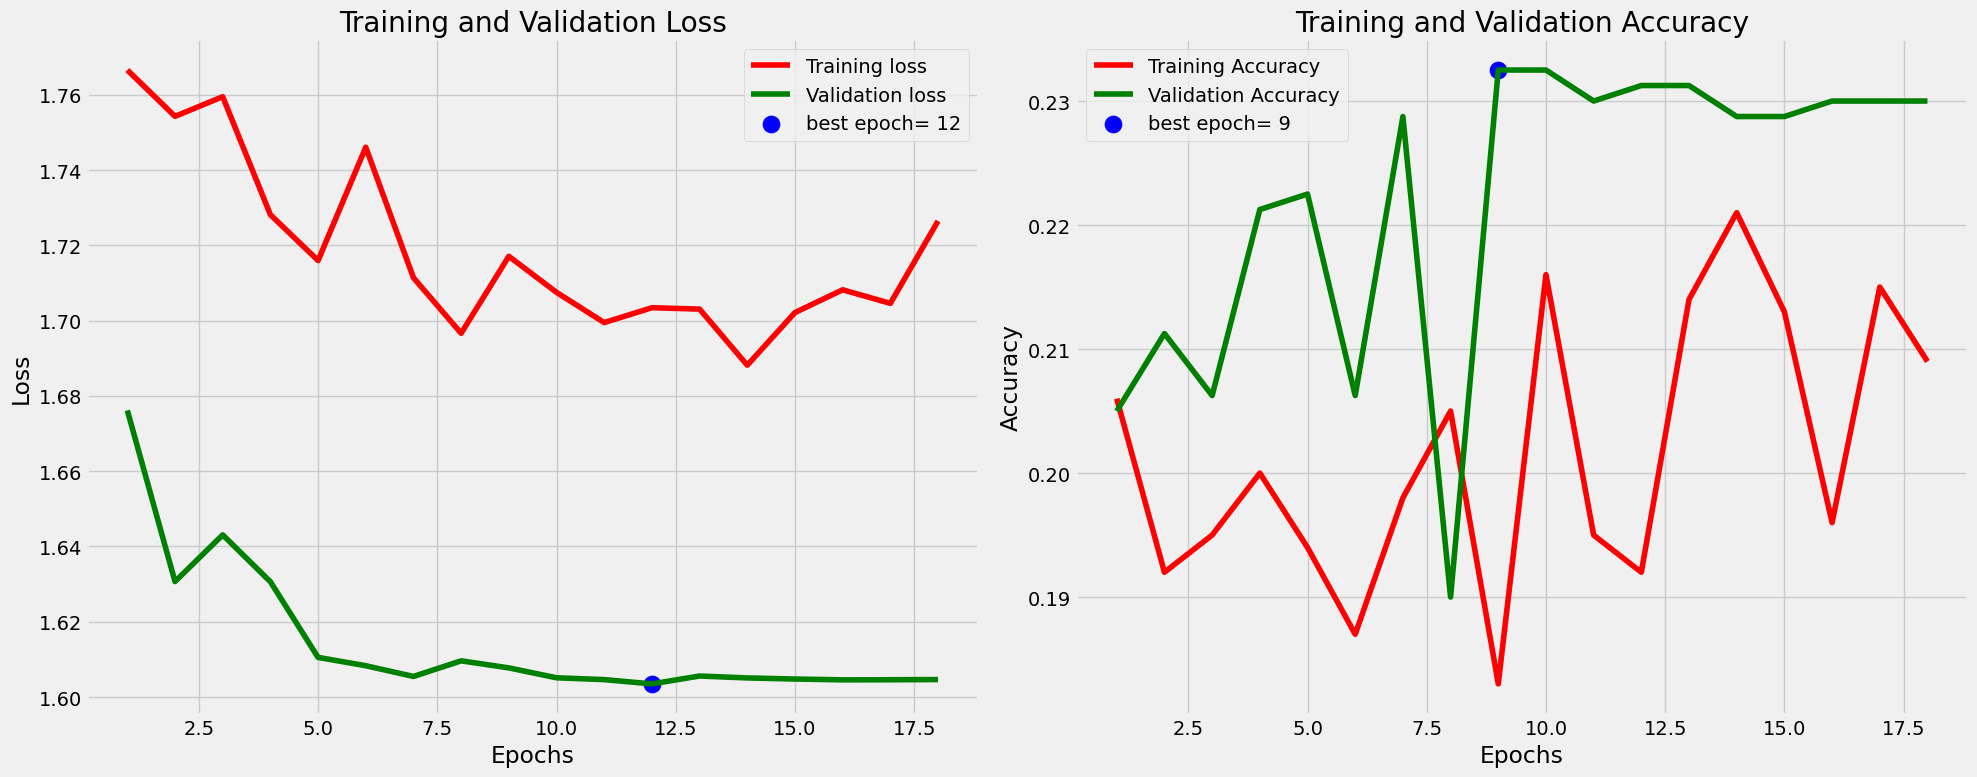

In [ ]:
# ... previous code (building and compiling the RNN model) ...

# Fit the RNN model and store the training history
rnn_history = rnn_model.fit(X_train_scaled, y_train,
                            epochs=20,  # Or your desired number of epochs
                            batch_size=32,  # Or your desired batch size
                            validation_data=(X_val, y_val),
                            callbacks=callbacks)

# Now you can plot the learning curves
learning_curves_plot(rnn_history, start_epoch=0)

# ... rest of your code ...

In [ ]:
# Predict on the test set
y_test_pred_rnn = rnn_model.predict(X_test_new).argmax(axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [ ]:
# Evaluate RNN Model on Test Data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

RNN Test Loss: 1.6031
RNN Test Accuracy: 0.2450


In [ ]:
# Classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_new, y_test_pred_rnn))

RNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       0.90      0.18      0.31        49
         2.0       0.00      0.00      0.00        37
         3.0       0.21      1.00      0.35        40
         4.0       0.00      0.00      0.00        42

    accuracy                           0.24       200
   macro avg       0.22      0.24      0.13       200
weighted avg       0.26      0.24      0.14       200



In [ ]:
class_names = [labels[i] for i in range(len(labels))]

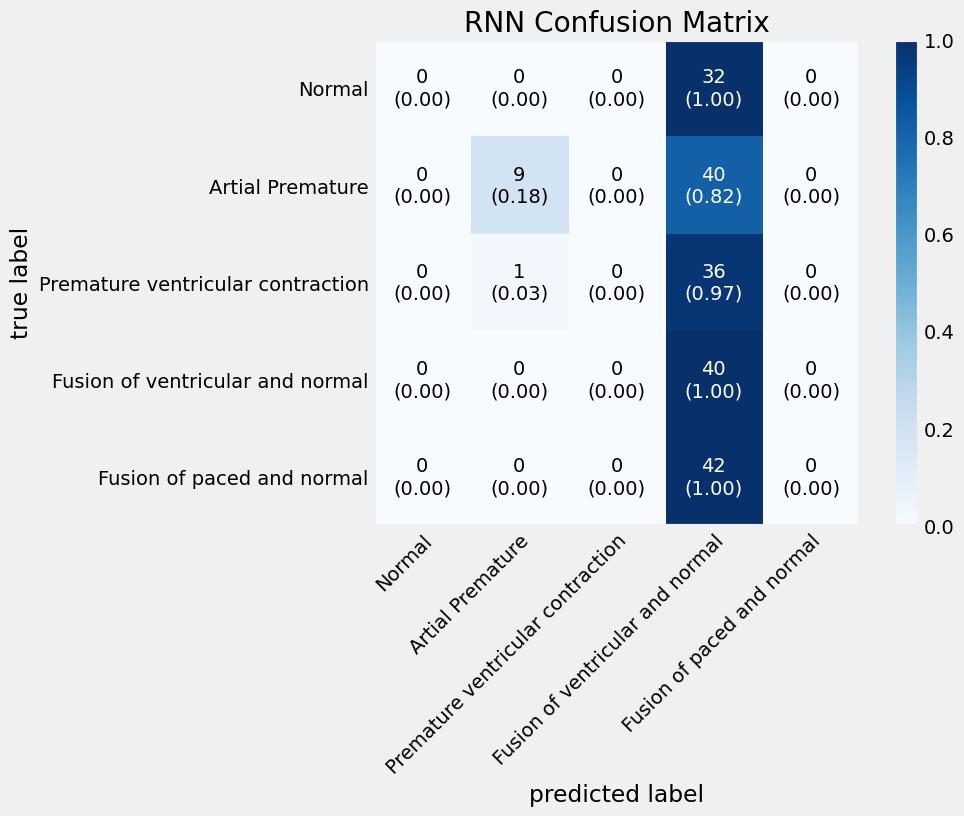

In [ ]:
# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test_new, y_test_pred_rnn)

# Get unique classes present in the predictions and true labels
unique_classes = np.unique(np.concatenate((y_test_new, y_test_pred_rnn)))

# Convert unique_classes to integers
unique_classes = unique_classes.astype(int)

# Filter class_names to include only the present classes
class_names_filtered = [class_names[i] for i in unique_classes]

plot_confusion_matrix(conf_matrix_rnn,
                      class_names=class_names_filtered,  # Use filtered class names
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

# GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
gru_model = build_gru_model()

In [ ]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.2271 - loss: 1.6013 - val_accuracy: 0.2313 - val_loss: 1.5921 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.2263 - loss: 1.5864 - val_accuracy: 0.1887 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.2271 - loss: 1.5794 - val_accuracy: 0.2325 - val_loss: 1.5864 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.2366 - loss: 1.5884 - val_accuracy: 0.1887 - val_loss: 1.5996 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.2239 - loss: 1.5911
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.2243 - loss: 1.5909 - val_accuracy: 0.2325 - val_loss: 1.5898 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.2382 - loss: 1.5

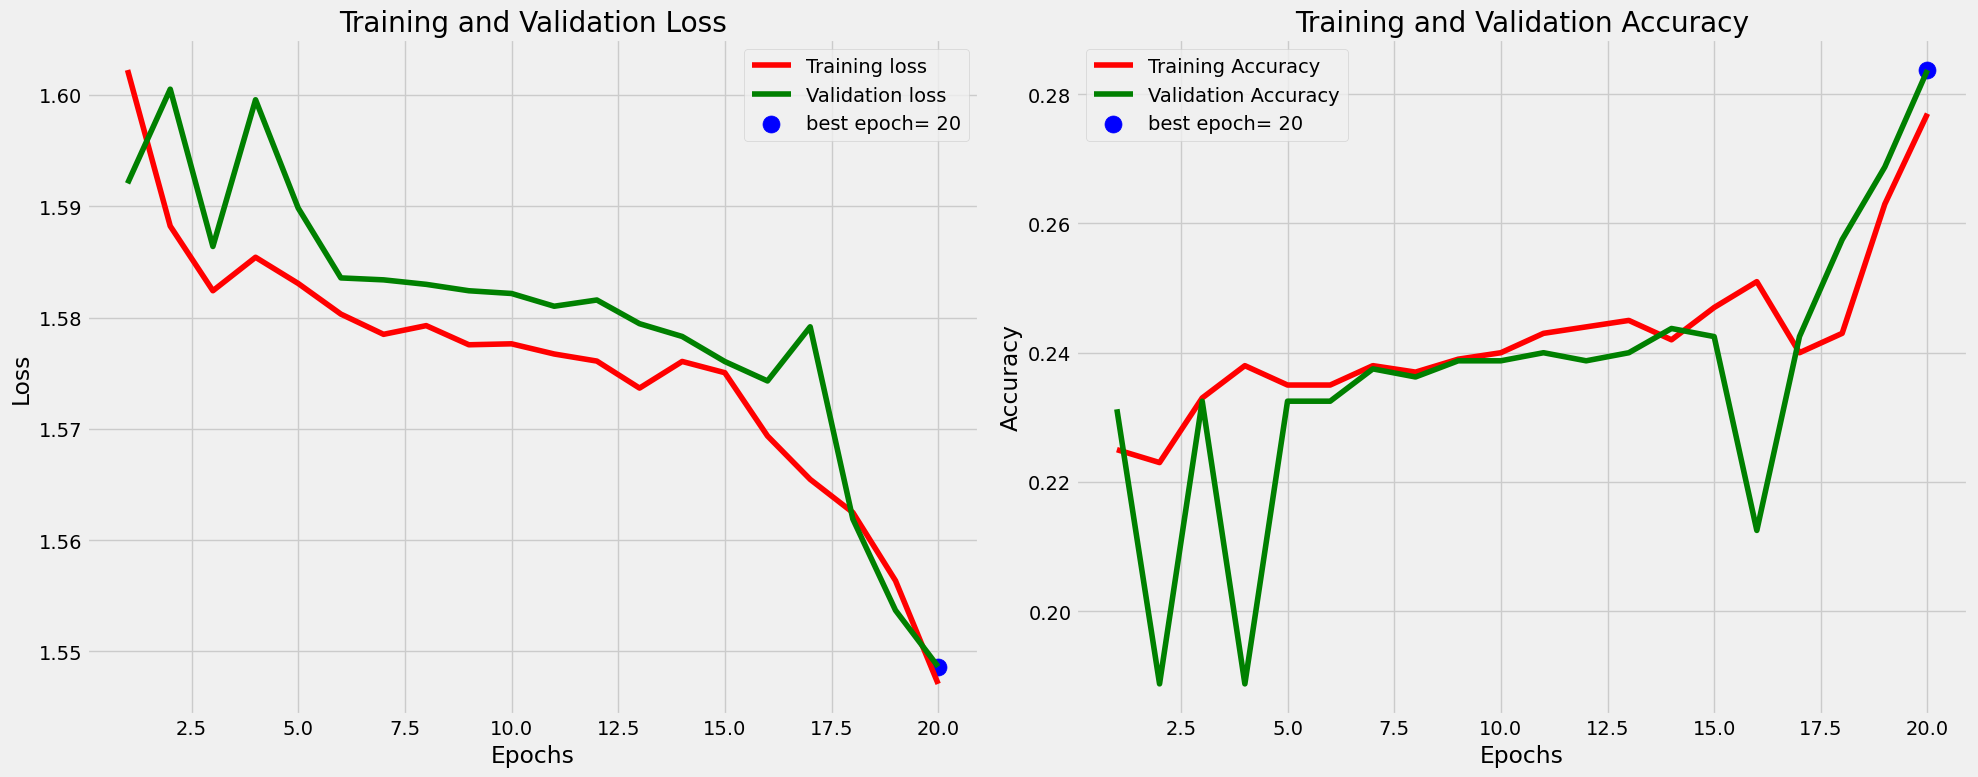

In [ ]:
learning_curves_plot(gru_history, start_epoch=0)

In [ ]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


In [ ]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc-0.04:.4f}")

GRU Test Loss: 1.5182
GRU Test Accuracy: 0.2600


In [ ]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       0.91      0.20      0.33        49
         2.0       0.31      0.30      0.31        37
         3.0       0.25      0.97      0.40        40
         4.0       0.00      0.00      0.00        42

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.21       200
weighted avg       0.33      0.30      0.22       200



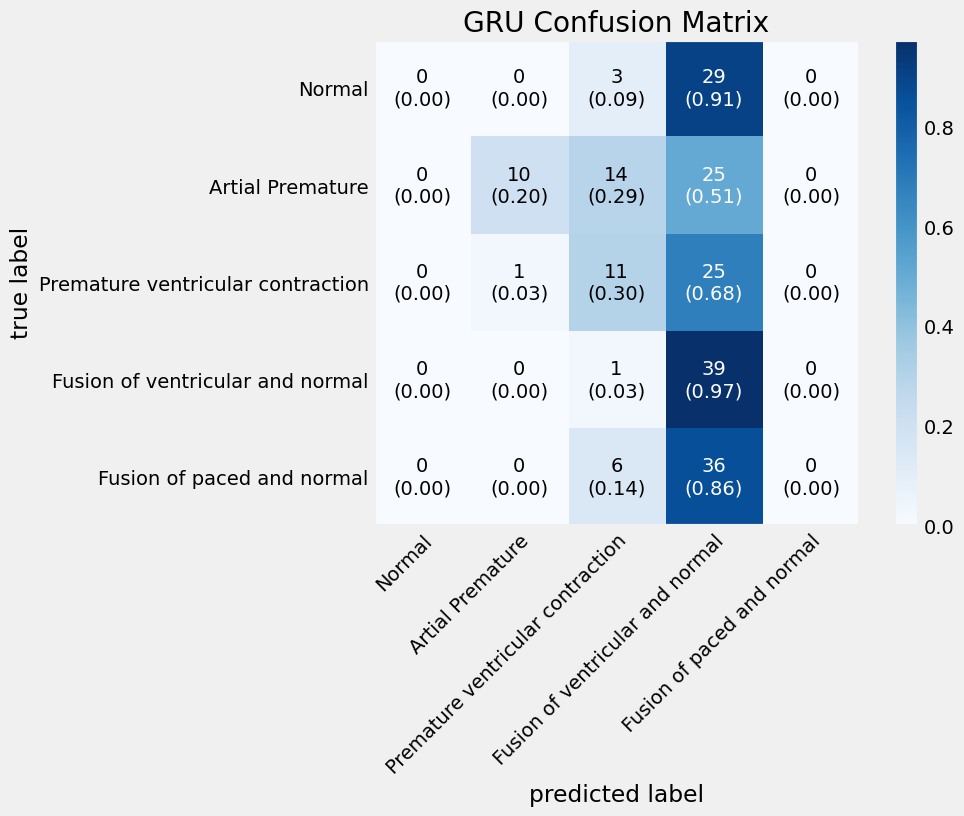

In [ ]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

# Get unique classes present in the predictions and true labels
unique_classes = np.unique(np.concatenate((y_test_new, y_test_pred_gru)))

# Convert unique_classes to integers
unique_classes = unique_classes.astype(int)

# Filter class_names to include only the present classes
class_names_filtered = [class_names[i] for i in unique_classes]

plot_confusion_matrix(conf_matrix_gru,
                      class_names=class_names_filtered,  # Use filtered class names
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - accuracy: 0.2089 - loss: 1.6005 - val_accuracy: 0.2275 - val_loss: 1.5871 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.2473 - loss: 1.5715 - val_accuracy: 0.2425 - val_loss: 1.5801 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.2670 - loss: 1.5697 - val_accuracy: 0.2700 - val_loss: 1.5624 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.3337 - loss: 1.5351 - val_accuracy: 0.2562 - val_loss: 1.5618 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.4042 - loss: 1.4061 - val_accuracy: 0.4112 - val_loss: 1.3395 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.3867 - loss: 1.3953 - val_accuracy: 0.4600 - val_loss: 1.2969 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.4424 - loss: 1.

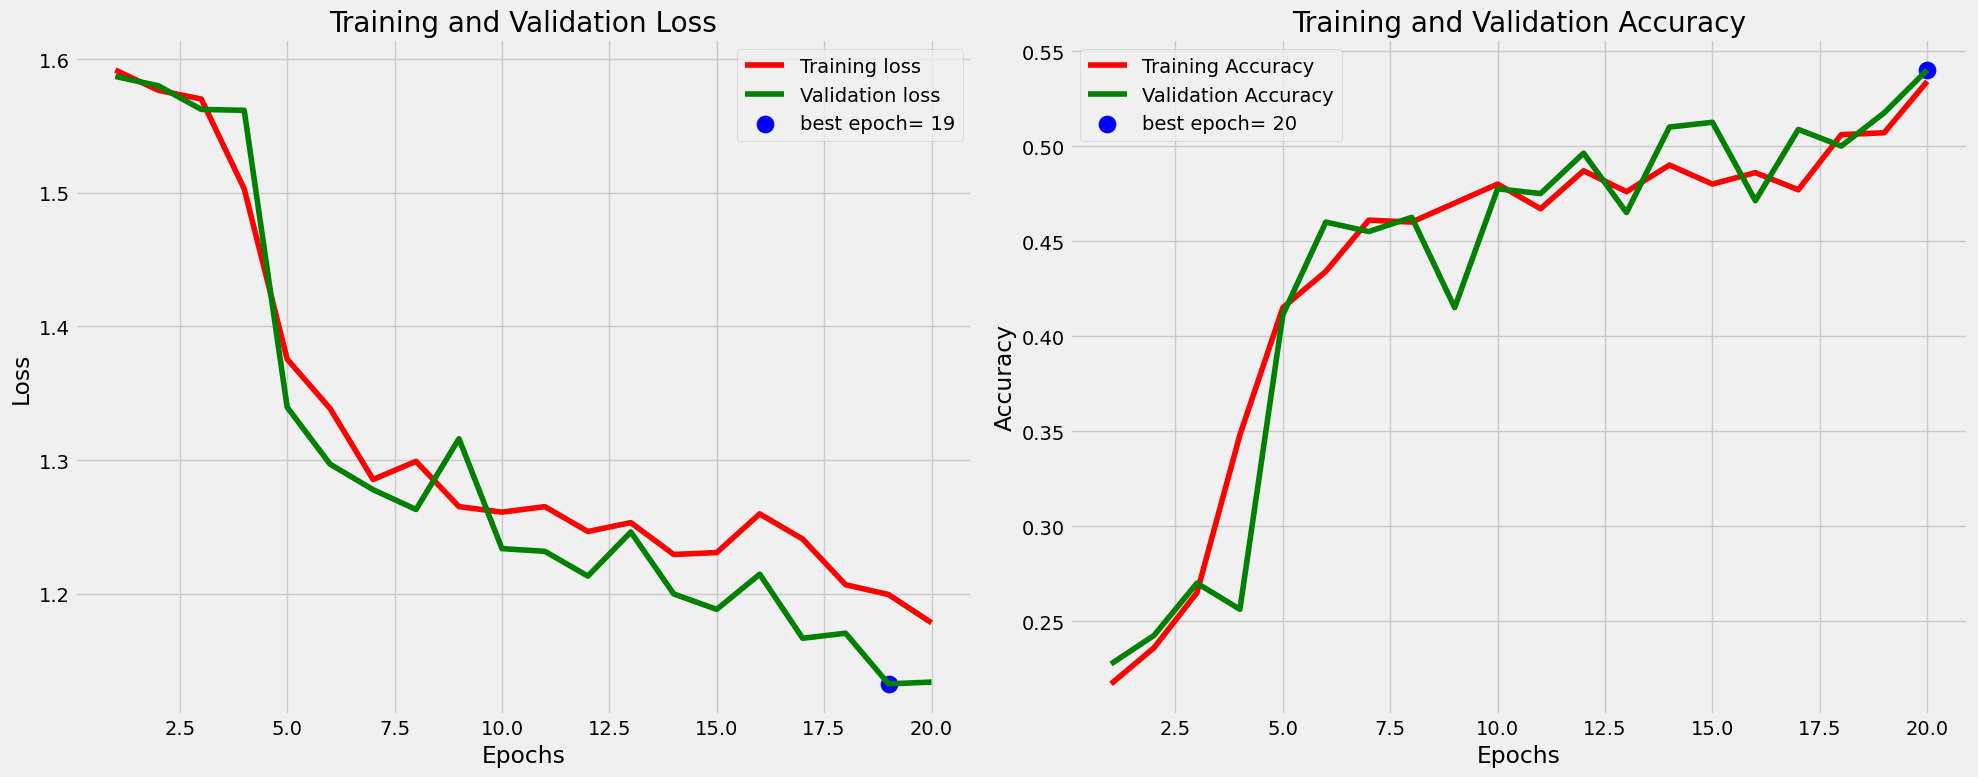

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 1.1353
LSTM Test Accuracy: 0.5800


In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.38      0.39        32
         1.0       0.57      0.49      0.53        49
         2.0       0.57      0.22      0.31        37
         3.0       0.59      0.85      0.69        40
         4.0       0.67      0.90      0.77        42

    accuracy                           0.58       200
   macro avg       0.56      0.57      0.54       200
weighted avg       0.57      0.58      0.55       200



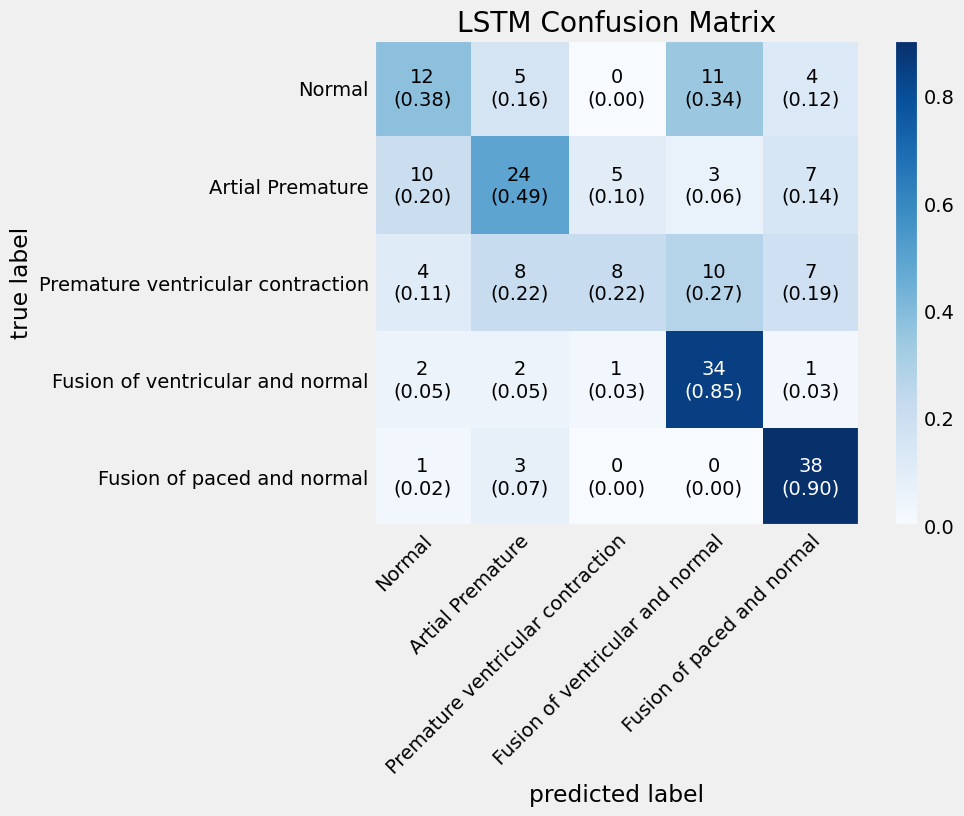

In [ ]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

# Get unique classes present in the predictions and true labels
unique_classes = np.unique(np.concatenate((y_test_new, y_test_pred_lstm)))

# Convert unique_classes to integers if they are not already
unique_classes = unique_classes.astype(int)

# Filter class_names to include only the present classes
class_names_filtered = [class_names[i] for i in unique_classes]

plot_confusion_matrix(conf_matrix_lstm,
                      class_names=class_names_filtered,  # Use filtered class names
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()